In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/master_thesis/_code/regional_model/regional_data/model1'

In [ ]:
import keras.backend as K
def custom_regional_nse(y_true, y_pred):

  numerator = K.square(y_pred - y_true)  # (batch_size, 2)
  dominator = K.square(y_true - K.mean(y_true)) + 0.1
  # summing both loss values along batch dimension 
  numerator_sum = K.sum(numerator, axis=1)        # (batch_size,)
  dominator_sum = K.sum(dominator, axis=1)        # (batch_size,)
  loss = (numerator_sum)/(dominator_sum)
  return loss # automatical average along batch size when optimization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import TimeDistributed, Dense, LSTM, RepeatVector, Dropout, Input, Flatten,Concatenate
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import glob,os
import random
from keras.models import Model
import os,shutil

# modified: only normalize the input instead of x and y
def split_regional_m3(static, path, dataset, n_input, n_output, scaler,shuffle): # 
    x1, x2,y,seq_static = list(),list(), list(), list()
    for j in range(len(dataset)):
        data_1 = pd.read_csv(path + dataset[j], index_col = 0)
        data_2 = pd.read_csv(path + dataset[j], index_col = 0) # not normalize y(target)
        # MinMax for individual event
        sequence = scaler.transform(data_1)
        cat = dataset[j].split('-')[3]
        catchment = cat.split('.')[0]
        ##################Catch raw value########## 27
        #temp_static = np.zeros((1,14))
        temp_static = np.zeros((1,27))
        temp_static = static[catchment].values # each basin one static input only one step
        for i in range(len(sequence)):
            # find the end of this pattern
            end_ix1 = i + n_input # runoff
            end_ix2 = i + n_input + n_output # others
            end_y = end_ix1 + n_output
            # check if we are beyond the sequence
            if end_ix1 > len(sequence):
                break
            if end_ix2 > len(sequence):
                break
            if end_y > len(sequence):
                break
            # gather input and output parts of the pattern
            seq_x2 = sequence[:,1:][i:end_ix2, :] # 3 rainfall, tmax and tmin -- add static to each time step
            seq_x1, seq_y = sequence[:,0][i:end_ix1], data_2.values[:,0][end_ix1:end_y] # 24 hours runoff and target runoff -- 0 to -1
            # concatnate temp_static and seq_x2
            # seq_x2 = np.concatenate((temp_x2,temp_static), axis= 1) # axis= 0, row to row
            x1.append(seq_x1)
            x2.append(seq_x2)
            y.append(seq_y)
            seq_static.append(list(temp_static))

    #shuffle
    x1, x2,y,seq_static = np.array(x1), np.array(x2), np.array(y), np.array(seq_static)
    number_list = np.arange(0,len(x1),1)
    random.shuffle(number_list) 
    x1_new = []
    for index in number_list:
        x1_new.append(x1[index])
    x2_new = []
    for index in number_list:
        x2_new.append(x2[index])
    y_new = []
    for index in number_list:
        y_new.append(y[index])
    static_new = []
    for index in number_list:
        static_new.append(seq_static[index])
    if shuffle:
        return np.array(x1_new), np.array(x2_new), np.array(y_new), np.array(static_new)
    else:
        return x1,x2, y, static_new

train_path = '/content/drive/My Drive/master_thesis/_code/regional_model/regional_data/train1/'
val_path = '/content/drive/My Drive/master_thesis/_code/regional_model/regional_data/val/'
test_path = '/content/drive/My Drive/master_thesis/_code/regional_model/regional_data/test/'

In [ ]:
### subregional
def split_subregional_m3(basins, static,path, dataset, n_input, n_output, scaler,shuffle): # 
    x1, x2,y,seq_static = list(),list(), list(), list()
    for j in range(len(dataset)):
        for basin in basins:
          if dataset[j].find(basin) != -1:
            data_1 = pd.read_csv(path + dataset[j], index_col = 0)
            data_2 = pd.read_csv(path + dataset[j], index_col = 0) # not normalize y(target)
            # MinMax for individual event
            sequence = scaler.transform(data_1)

            cat = dataset[j].split('-')[3]
            catchment = cat.split('.')[0]
            temp_static = np.zeros((1,14))
            temp_static = static[catchment].values # each basin one static input only one step
            for i in range(len(sequence)):
                # find the end of this pattern
                end_ix1 = i + n_input # runoff
                end_ix2 = i + n_input + n_output # others
                end_y = end_ix1 + n_output
                # check if we are beyond the sequence
                if end_ix1 > len(sequence):
                    break
                if end_ix2 > len(sequence):
                    break
                if end_y > len(sequence):
                    break
                # gather input and output parts of the pattern
                seq_x2 = sequence[:,1:][i:end_ix2, :] # 3 rainfall, tmax and tmin -- add static to each time step
                seq_x1, seq_y = sequence[:,0][i:end_ix1], data_2.values[:,0][end_ix1:end_y] # 24 hours runoff and target runoff -- 0 to -1
                # concatnate temp_static and seq_x2
                # seq_x2 = np.concatenate((temp_x2,temp_static), axis= 1) # axis= 0, row to row
                x1.append(seq_x1)
                x2.append(seq_x2)
                y.append(seq_y)
                seq_static.append(list(temp_static))


    #shuffle
    x1, x2,y,seq_static = np.array(x1), np.array(x2), np.array(y), np.array(seq_static)
    number_list = np.arange(0,len(x1),1)
    random.shuffle(number_list) 
    x1_new = []
    for index in number_list:
        x1_new.append(x1[index])
    x2_new = []
    for index in number_list:
        x2_new.append(x2[index])
    y_new = []
    for index in number_list:
        y_new.append(y[index])
    static_new = []
    for index in number_list:
        static_new.append(seq_static[index])
    if shuffle:
        return np.array(x1_new), np.array(x2_new), np.array(y_new), np.array(static_new)
    else:
        return x1,x2, y, static_new

In [ ]:
nse_table = pd.read_csv( '/content/drive/My Drive/master_thesis/_code/regional_model/regional_data/basin_name.csv',index_col = 0)
basins = nse_table.columns

In [ ]:
### test axis = 1; previously used 0
# add static variable to each time step -- pre-normalization not minmax -- negative value here for PCA scores
# read static
pca_score = pd.read_csv( '/content/drive/My Drive/master_thesis/_code/regional_model/regional_data/pca_score.csv',index_col = 0)
# normalization -1 - 1 by each PC
temp2 = pca_score.values
temp_nor = preprocessing.normalize(temp2, norm='l2',axis = 1) # default for each column axis= 1
pca_score_nor = pd.DataFrame(temp_nor, index=[pca_score.index], columns=pca_score.columns)

In [ ]:
pca_score_nor

In [ ]:
#########################NEW###################################
# add static variable to each time step -- pre-normalization not minmax -- negative value here for PCA scores
# read static
pca_score = pd.read_csv( '/content/drive/My Drive/master_thesis/_code/regional_model/regional_data/cat_static.csv',index_col = 0)
# normalization -1 - 1 by each PC
temp2 = pca_score.values
temp_nor = preprocessing.normalize(temp2, norm='l2',axis = 0) # default for each column axis= 1;1 or 0????
pca_score_nor = pd.DataFrame(temp_nor, index=[pca_score.index], columns=pca_score.columns)

In [ ]:
pca_score_nor

In [ ]:
# dataset split
# import data for train, val and test

trainlist=os.listdir(train_path)
vallist=os.listdir(val_path)
testlist=os.listdir(test_path)

# all data should use this scaler--fit the scaler using all data
df2 = pd.DataFrame()

for j in range(len(trainlist)):
    data = pd.read_csv(train_path + trainlist[j], index_col = 0)
    df2 = pd.concat([df2,data],axis=0) 
temp = df2.values
min_max_scaler1 = MinMaxScaler() # default for each column
min_max_scaler1.fit(temp) # only fit--apply this to the sequence window for normalization

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
####subregional#####
# dataset split -- for sub-regional model
# import data for train, val and test

trainlist=os.listdir(train_path)
vallist=os.listdir(val_path)
testlist=os.listdir(test_path)

# all data should use this scaler--fit the scaler using all data
df2 = pd.DataFrame()


for j in range(len(trainlist)):
  for basin in basins:
    if trainlist[j].find(basin) != -1:
      data = pd.read_csv(train_path + trainlist[j], index_col = 0)
      df2 = pd.concat([df2,data],axis=0) 

temp = df2.values
min_max_scaler1 = MinMaxScaler() # default for each column
min_max_scaler1.fit(temp) # only fit--apply this to the sequence window for normalization

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
# input for training model
train1_x, train2_x, train_y, train_static = split_regional_m3(pca_score_nor,train_path, trainlist, 24, 6,min_max_scaler1,shuffle =True)
#train1_x, train2_x, train_y = split_multi_sequence_keras(train_val, 24, 6,min_max_scaler1,shuffle =True)

# input for validation model -- using test
val1_x, val2_x, val_y, val_static = split_regional_m3(pca_score_nor,test_path, testlist, 24, 6, min_max_scaler1,shuffle =True)
#val1_x, val2_x, val_y = split_multi_sequence_keras(test, 24, 6, min_max_scaler1,shuffle =True)

val1_x = val1_x.reshape((val1_x.shape[0],val1_x.shape[1],1)) 
train1_x = train1_x.reshape((train1_x.shape[0],train1_x.shape[1],1))
### only necessary when encoder layer is lstm
#train_static = train_static.reshape((train_static.shape[0],1,train_static.shape[1]))
#val_static = val_static.reshape((val_static.shape[0],1,val_static.shape[1]))

In [ ]:
val_static.shape

(23725, 27)

In [ ]:
# define customer optimizer
RMSprop=keras.optimizers.RMSprop(lr=0.0001)

# define special callbacks
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=15, cooldown=30, min_lr=1e-8)
######## early longer ########
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, verbose=2)
# design network
dim_dense=[512, 256, 256, 128, 64]

# input of runoff observation, LSTM encoder
input_1 = Input(shape=(train1_x.shape[1],train1_x.shape[2]), name='LSTM1_input') # shape should be 72*1 for runoff observation
LSTM1 = LSTM(256, return_sequences=False)(input_1)

# input of runoff observation and forecast, LSTM encoder
input_2 = Input(shape=(train2_x.shape[1],train2_x.shape[2]), name='LSTM2_input') # shape should be (72+24)*n=96*n, for rainfall observation (72) and predictions (24) for n stations (if there is no upstream station, n=1)
LSTM2 = LSTM(256, return_sequences=False)(input_2)

# input of other non-timeseries data, such as daily or monthly data.
#input_static = Input(shape=(14,), name='static_input') # shape = 14 -- 14 static variables -- 2D in this case with only Input or Dense layer (14,)/3D for LSTM layer (1,14)
#Layer3 = Dense(16, activation='relu')(input_static)
#LSTM_static = LSTM(256, return_sequences=False)(input_static)
#######27 catchment static#########
input_static = Input(shape=(27,), name='static_input') # shape = 14 -- 14 static variables -- 2D in this case with only Input or Dense layer (14,)/3D for LSTM layer (1,14)
Layer3 = Dense(32, activation='relu')(input_static)


# connect all data
x = Concatenate()([Layer3, LSTM1, LSTM2]) # Get state vector.default is axis = -1
x = RepeatVector(6)(x)  # 6 hour ahead

# LSTM decoder
x = LSTM(512, return_sequences=True)(x)

# final fully-connected layer for final result
for dim in dim_dense:
	x = TimeDistributed(Dense(dim, activation='relu'))(x)
	x = TimeDistributed(Dropout(0.4))(x) # Some dropout for dense layers.
main_out = TimeDistributed(Dense(1, activation='relu'))(x) 
main_out = Flatten()(main_out)

model = Model(inputs=[input_static, input_1, input_2], outputs=main_out)
#model.compile(optimizer=RMSprop, loss='mse')
model.compile(optimizer=RMSprop, loss=custom_regional_nse) 
model.summary()

# fit network
history = model.fit([train_static, train1_x, train2_x], train_y, epochs=300, batch_size=128,
					validation_data=([val_static, val1_x, val2_x], val_y), callbacks=[reduce_lr,early_stopping], verbose=1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
static_input (InputLayer)       [(None, 27)]         0                                            
__________________________________________________________________________________________________
LSTM1_input (InputLayer)        [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
LSTM2_input (InputLayer)        [(None, 30, 3)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           896         static_input[0][0]               
______________________________________________________________________________________________

In [ ]:
from keras.models import load_model
model.save('/content/drive/My Drive/master_thesis/_code/regional_model/model3_catch0.h5' ) # batch 32--11.10 -- version 2

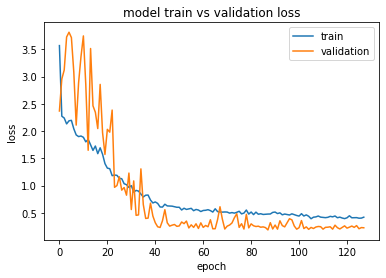

In [ ]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title( 'model train vs validation loss') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend([ 'train', 'validation'], loc= 'upper right') 
plt.show()